In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = './results'

## Portfolio problem

In [20]:
task_name = 'portfolio'
data_list =  ['syn_1000_800_10_50', 'syn_1000_1200_10_50', 'syn_1000_1500_10_50']
policy_list = run_alpha_policies = ["standard","line_search","icml","scopt"]
results = dict()

for data_name in data_list:
    file_path = os.path.join(data_folder, task_name, data_name + '.pckl')
    with open(file_path, 'rb') as f:
        results[data_name] = pickle.load(f)

In [4]:
f_optim_values, error_hist_data, time_hist_data = {}, {}, {}

# calculate relative errors and save it (with time data)
for data_name in data_list:
    data_results = results[data_name][data_name]
    f_min = min([data_results[policy]['Q_hist'][-1] for policy in data_results.keys()])
    f_optim_values[data_name] = f_min
    for policy in data_results.keys():
        errors = [abs(f_val - f_min) / abs(f_min) for f_val in data_results[policy]['Q_hist']]
        if policy not in error_hist_data.keys():
            error_hist_data[policy] = {}
            time_hist_data[policy] = {}
        error_hist_data[policy][data_name] = np.array(errors)
        time_hist_data[policy][data_name] = np.array(data_results[policy]['time_hist'])

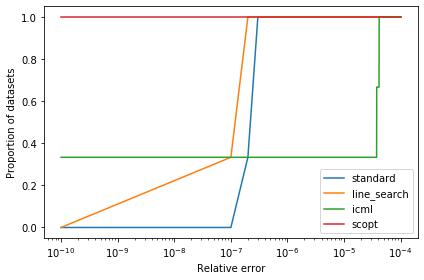

In [48]:
#dataset percentage plot
policy_percentage_plot = {}
for policy in error_hist_data.keys():
    error_range = np.arange(1e-10, 1e-4, 1e-7)
    achieved_error_data_qty = []
    for error_val in error_range:
        curr_error_achieved_qty = 0
        for error_hist in error_hist_data[policy].values():
            if (len(error_hist) < 10000) or (error_hist[5000] < error_val):
                curr_error_achieved_qty += 1
        achieved_error_data_qty.append(curr_error_achieved_qty)
    policy_percentage_plot[policy] = achieved_error_data_qty
for policy in policy_percentage_plot:
    plt.plot(error_range, np.array(policy_percentage_plot[policy]) / len(data_list), label=policy)

plt.legend()
plt.xscale('log')
plt.xlabel('Relative error')
plt.ylabel(('Proportion of datasets'))
plt.tight_layout()
plt.savefig('./pics/dataset_proportion_plot.png')
plt.show()

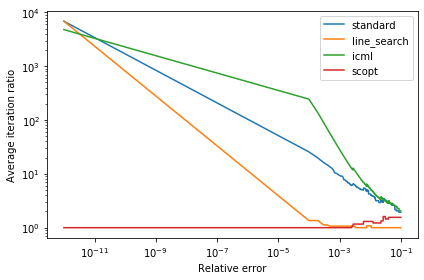

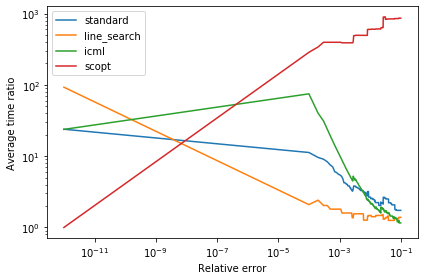

In [50]:
#average ratio iter plot
minimal_iter_per_algo = {}
minimal_time_per_algo = {}

for policy in error_hist_data.keys():
    error_range = np.arange(1e-12, 1e-1, 1e-4)
    for data_name, error_hist in error_hist_data[policy].items():
        current_data_minimal_iters = []
        current_data_minimal_times = []
        for error_val in error_range:
            if any(error_hist < error_val):
                # find index of first error that lower than threshold (+1 since numeration starts from 0)
                iter_index = np.argmax(error_hist < error_val) + 1
                current_data_minimal_iters.append(iter_index)
                current_data_minimal_times.append(np.sum(time_hist_data[policy][data_name][:iter_index]))
            else:
                current_data_minimal_iters.append(len(error_hist))
                current_data_minimal_times.append(np.sum(time_hist_data[policy][data_name]))
        if policy not in minimal_iter_per_algo.keys():
            minimal_iter_per_algo[policy] = {}
            minimal_time_per_algo[policy] = {}
        minimal_iter_per_algo[policy][data_name] = current_data_minimal_iters
        minimal_time_per_algo[policy][data_name] = current_data_minimal_times

ratio_of_iter_per_algo = {}
ratio_of_time_per_algo = {}

for data_name in data_list:
    for i in range(len(error_range)):
        iters_over_policies = [minimal_iter_per_algo[policy][data_name][i] for policy in policy_list]
        times_over_policies = [minimal_time_per_algo[policy][data_name][i] for policy in policy_list]
        minimal_iter_val = min(iters_over_policies)
        minimal_time_val = min(times_over_policies)
        for policy in policy_list:
            if policy not in ratio_of_iter_per_algo.keys():
                ratio_of_iter_per_algo[policy] = {}
                ratio_of_time_per_algo[policy] = {}
            if data_name not in ratio_of_iter_per_algo[policy].keys():
                ratio_of_iter_per_algo[policy][data_name] = []
                ratio_of_time_per_algo[policy][data_name] = []
            ratio_of_iter_per_algo[policy][data_name].append(minimal_iter_per_algo[policy][data_name][i] / minimal_iter_val)
            ratio_of_time_per_algo[policy][data_name].append(minimal_time_per_algo[policy][data_name][i] / minimal_time_val)

for policy in policy_list:
    policy_avg_ratios = []
    for i in range(len(error_range)):
        policy_avg_ratios.append(np.mean([ratio_of_iter_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_ratios, label=policy)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average iteration ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/avg_iter_plot.png')
plt.show()

for policy in policy_list:
    policy_avg_time_ratios = []
    for i in range(len(error_range)):
        policy_avg_time_ratios.append(np.mean([ratio_of_time_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_time_ratios, label=policy)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average time ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/avg_time_plot.png')
plt.show()

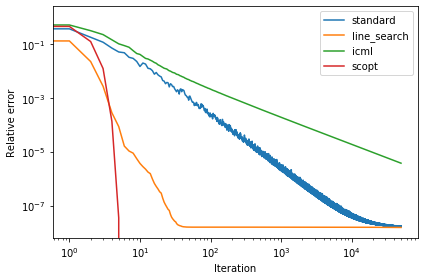

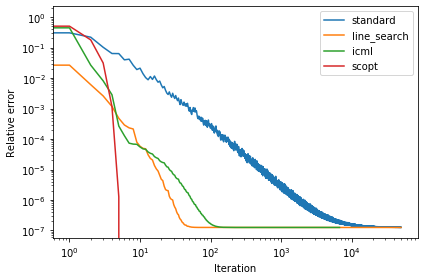

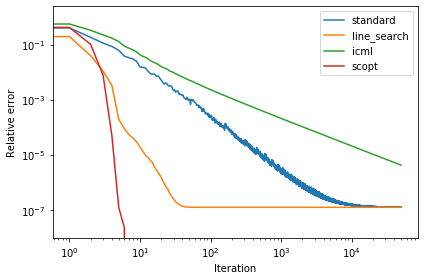

In [57]:
for data in data_list:
    for policy in policy_list:
        plt.plot(error_hist_data[policy][data], label=policy)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Relative error')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join('./pics', data + '.png'))
    plt.show()

In [21]:
ratio_of_iter_per_algo = {}

for data_name in data_list:
    for i in range(len(error_range)):
        iters_over_policies = [minimal_iter_per_algo[policy][data_name][i] for policy in policy_list]
        minimal_iter_val = min(iters_over_policies)
        for policy in policy_list:
            if policy not in ratio_of_iter_per_algo.keys():
                ratio_of_iter_per_algo[policy] = {}
            if data_name not in ratio_of_iter_per_algo[policy].keys():
                ratio_of_iter_per_algo[policy][data_name] = []
            ratio_of_iter_per_algo[policy][data_name].append(minimal_iter_per_algo[policy][data_name][i] / minimal_iter_val)

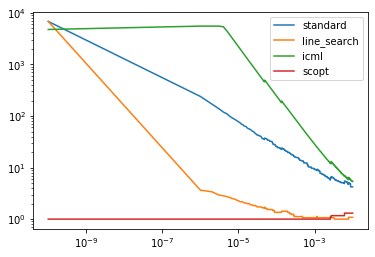

In [38]:
for policy in policy_list:
    policy_avg_ratios = []
    for i in range(len(error_range)):
        policy_avg_ratios.append(np.mean([ratio_of_iter_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_ratios, label=policy)
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.show()

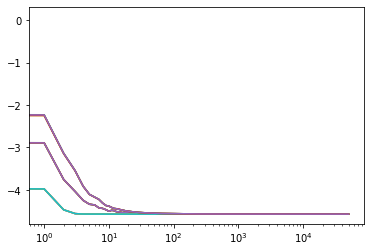

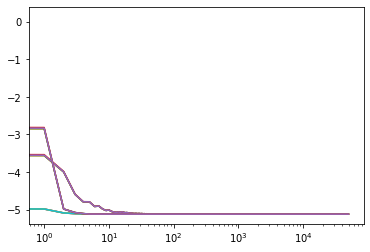

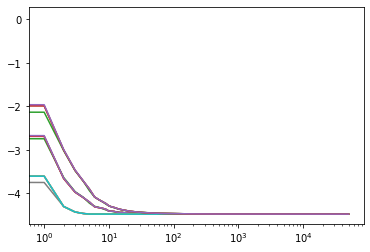

In [9]:
problem_name = 'portfolio'
data_list = ['syn_1000_800_10_50', 'syn_1000_1200_10_50', 'syn_1000_1500_10_50']
policy_list = ["standard", "line_search", "icml"]

for data in data_list:
    with open()
    for policy in policy_list:
        file_name = os.path.join(data_folder, problem_name, data + '_' + policy + '.pckl')
        with open(file_name, 'rb') as f:
            file_data = pickle.load(f)
        for start_point in file_data:
            func_hist = start_point['Q_hist']
            time_hist = start_point['time_hist']
            plt.plot(func_hist)
            plt.xscale('log')
    plt.show()